In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phase_mixing_utils
import phase_retrieval

/Users/jgreisman/anaconda2/lib/python2.7/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
# Generate ring structure
def_uc = 100
rings = phase_mixing_utils.rings()
ft_rings = np.fft.fft2(rings)

uc = rings[:100,:100]
uc = (uc - uc.min()) / (uc.max() - uc.min())
ft_rings = np.fft.fft2(uc)
mags = phase_mixing_utils.get_mag(ft_rings)
phases = phase_mixing_utils.get_phase(ft_rings)

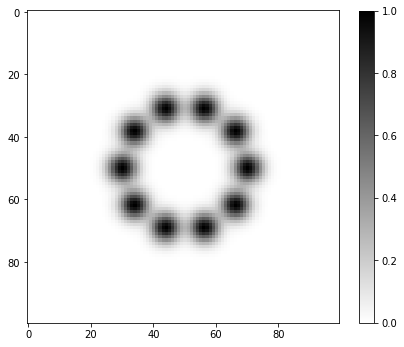

In [3]:
plt.figure(figsize=(7, 7))
plt.imshow(uc, cmap='gray_r')
plt.colorbar(shrink=0.82)

In [74]:
def fourier_MSE(guess, reference): 
    """MSE in Fourier domain"""
    abs_err = np.sum((np.abs(guess) - np.abs(reference))**2)
    norm = np.sum(np.abs(reference)**2)
    return abs_err/norm

def inputoutput(mags, guess=None, n_iters=1000, beta=0.3, freq=0.5):
    """
    Implementation of the input-output phase retrieval algorithm from 
    Fienup JR, Optics Letters (1978). 
    
    Parameters
    ----------
    mags : np.ndarray
        Array of magnitudes in Fourier space (modulus of Fourier transform)
    n_iters : int
        Number of iterations to run algorithm
    beta : float
        Scaling factor for updates to negative real-space components in iteration 
        of input-output algorithm
    freq : float
        Switching frequency between input-output updates to real-space density and
        error-reduction updates. If 1.0, input-output updates are always used. If
        0.0, negative real-space values are zeroed out at every iteration. (Default 
        value is 0.5)
        
    Returns
    -------
    (rs_track, error_track)
        The first array contains the estimate of the real-space density at each iteration.
        The second array contains the Fourier domain mean-squared error at each iteration.
    """
    # Initialize with guess if provided. Otherwise, generate random starting guess.
    shape = list(mags.shape)
    if guess is None:
        rs_const = np.random.random_sample(shape)
    else:
        assert guess.shape == mags.shape
        rs_const = guess
        
    rs_track  = np.zeros([n_iters+1] + shape)
    rs_track[0]= rs_const
    err_track = np.zeros(n_iters)
    
    for i in range(n_iters):
        
        ft = np.fft.fft2(rs_const)
        err_track[i] = fourier_MSE(ft, mags)
        
        # Mix known magnitudes and guessed phases
        ks_est = mags*np.exp(1j*phase_mixing_utils.get_phase(ft))
        
        # Inverse fourier transfrom your phase guess with the given magnitudes
        rs_est = np.fft.ifft2(ks_est)
        
        # Impose desired real-space density constraint
        gamma  = np.real(rs_est) > 0 # Mask of negative density
        if np.random.rand() < 0.5:
            # Input-Output update
            rs_const = np.abs(rs_est*gamma - (rs_est*(~gamma)*beta)) 
        else:
            # Error-Reduction update
            rs_const = np.abs(rs_est*gamma)
        rs_track[i+1] = rs_const
    
    return rs_track, err_track

In [52]:
n_iters = 10000

rs_const = np.random.rand(100, 100)

rs_track = np.zeros((n_iters+1,uc.shape[0],uc.shape[1]))
rs_track[0]= rs_const
ks_err_track = np.zeros(n_iters) #Compute the error in k-space per the Fineup article I sent
beta = 0.5
for i in range(n_iters):

    ft = np.fft.fft2(rs_const)
    ks_err_track[i] = fourier_MSE(ft,mags)

    #Mix known magnitudes and guessed phases
    ks_est = mags*np.exp(1j*phase_mixing_utils.get_phase(ft))

    #Inverse fourier transfrom your phase guess with the given magnitudes
    rs_est = np.fft.ifft2(ks_est)

    #Require the real part of the real space estimate be positive, set others to zero
    gamma  = np.real(rs_est)>0
    if np.random.rand() < 0.5:
        rs_const = np.abs(rs_est*gamma - (rs_est*(~gamma)*beta))
    else:
        rs_const = np.abs(rs_est*gamma)
    rs_track[i+1] = rs_const

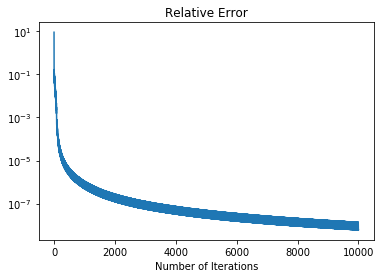

In [54]:
plt.semilogy(ks_err_track)
plt.title(r"Relative Error")
plt.xlabel(r"Number of Iterations")
plt.show()

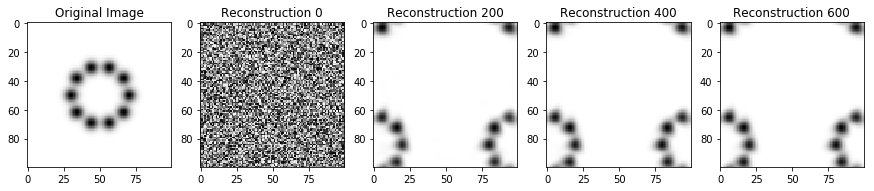

In [44]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
ax[0].imshow(uc, cmap='gray_r')
ax[0].set_title("Original Image")
for i in range(4):
    ax[i+1].imshow(rs_track[i*200], cmap='gray_r')
    ax[i+1].set_title("Reconstruction %d" %(i*200))

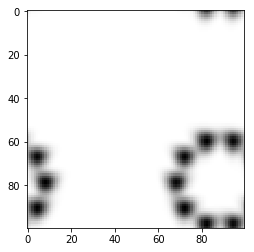

In [8]:
plt.imshow(rs_track[-1], cmap="gray_r")

In [9]:
# for i, img in enumerate(rs_track[:500:1]):
#     plt.imshow(img, cmap="gray_r")
#     plt.title("Iteration %d" %(i*1))
#     plt.savefig("movie/img%04d.png" %i)

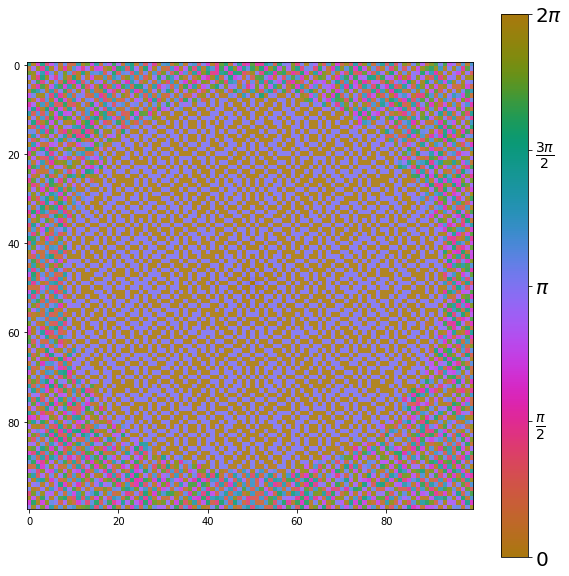

In [45]:
phase_mixing_utils.phase_intensity_plot(np.fft.fftshift(ft_rings), min_alpha=0.9, cb=True)

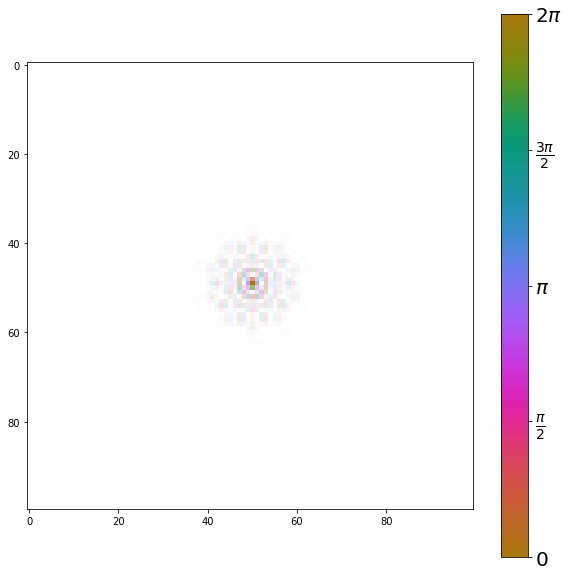

In [13]:
phase_mixing_utils.phase_intensity_plot(np.fft.fftshift(ft), cb=True)

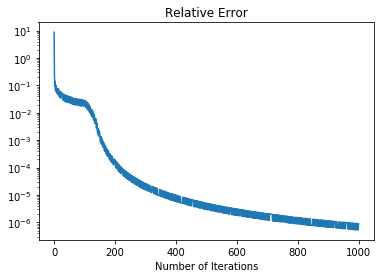

In [6]:
rstrack, err_track = phase_retrieval.inputoutput(mags)
plt.semilogy(err_track)
plt.title(r"Relative Error")
plt.xlabel(r"Number of Iterations")
plt.show()

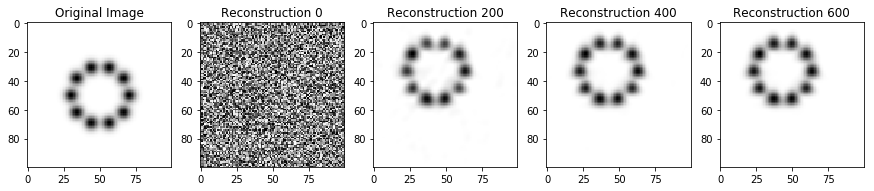

In [7]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
ax[0].imshow(uc, cmap='gray_r')
ax[0].set_title("Original Image")
for i in range(4):
    ax[i+1].imshow(rstrack[i*200], cmap='gray_r')
    ax[i+1].set_title("Reconstruction %d" %(i*200))